In [0]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [0]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wih = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bi = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #forget gate
        ##################### TO DO #####################
        self.Wfx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wfh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bf = Parameter(torch.Tensor(hiddensz, 1))
        #c gate
        ##################### TO DO #####################
        self.Wcx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wch = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bc = Parameter(torch.Tensor(hiddensz, 1))
        
        #output gate
        ##################### TO DO #####################
        self.Wox =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Woh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bo = Parameter(torch.Tensor(hiddensz, 1))
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht = torch.zeros(self.hiddensz, 1)
            ct = torch.zeros(self.hiddensz, 1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it =  torch.sigmoid((self.Wix @ xt) + (self.Wih @ ht) + self.bi) 
            ft =  torch.sigmoid((self.Wfx @ xt) + (self.Wfh @ ht) + self.bf) 
            gt =  torch.tanh((self.Wcx @ xt) + (self.Wch @ ht) + self.bc) 
            ot =   torch.sigmoid((self.Wox @ xt) + (self.Woh @ ht) + self.bo) 
            ct =   (ft * ct) + (it * gt)
            ht =   ot * torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [0]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [0]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [60]:
addData(20)

(tensor([[ 0.3554,  0.0000],
         [-0.2301,  0.0000],
         [-0.3239,  1.0000],
         [-0.0558,  1.0000],
         [-0.2477,  0.0000],
         [-0.2500,  0.0000],
         [-0.4901,  0.0000],
         [-0.2813,  0.0000],
         [-0.0502,  0.0000],
         [ 0.1779,  0.0000],
         [ 0.3116,  0.0000],
         [ 0.2821,  0.0000],
         [-0.4049,  0.0000],
         [-0.3126,  0.0000],
         [-0.4952,  0.0000],
         [-0.3894,  0.0000],
         [ 0.1449,  0.0000],
         [-0.4784,  0.0000],
         [ 0.1287,  0.0000],
         [-0.4852,  0.0000],
         [ 0.4269,  0.0000]]), tensor(-0.3798))

In [0]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [0]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [63]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 6.4028,val Loss: 0.8759
Epoch: 2/100............. training: 0.6640,val Loss: 0.1811
Epoch: 3/100............. training: 0.1952,val Loss: 0.2068
Epoch: 4/100............. training: 0.1543,val Loss: 0.2339
Epoch: 5/100............. training: 0.1501,val Loss: 0.2358
Epoch: 6/100............. training: 0.1476,val Loss: 0.2306
Epoch: 7/100............. training: 0.1452,val Loss: 0.2257
Epoch: 8/100............. training: 0.1428,val Loss: 0.2221
Epoch: 9/100............. training: 0.1405,val Loss: 0.2191
Epoch: 10/100............. training: 0.1382,val Loss: 0.2162
Epoch: 11/100............. training: 0.1359,val Loss: 0.2135
Epoch: 12/100............. training: 0.1337,val Loss: 0.2108
Epoch: 13/100............. training: 0.1316,val Loss: 0.2082
Epoch: 14/100............. training: 0.1296,val Loss: 0.2056
Epoch: 15/100............. training: 0.1275,val Loss: 0.2032
Epoch: 16/100............. training: 0.1256,val Loss: 0.2008
Epoch: 17/100............. traini

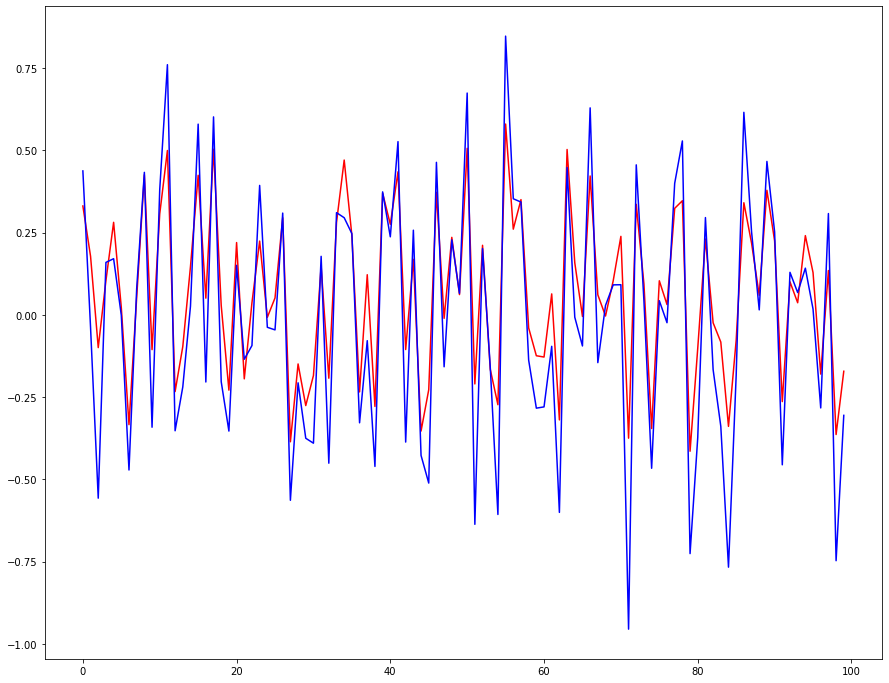

In [64]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [0]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [0]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [0]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [68]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.1572,val Loss: 0.1420
Epoch: 2/100............. training: 0.1373,val Loss: 0.1314
Epoch: 3/100............. training: 0.1303,val Loss: 0.1255
Epoch: 4/100............. training: 0.1241,val Loss: 0.1155
Epoch: 5/100............. training: 0.1077,val Loss: 0.0824
Epoch: 6/100............. training: 0.0674,val Loss: 0.0506
Epoch: 7/100............. training: 0.0533,val Loss: 0.0505
Epoch: 8/100............. training: 0.0517,val Loss: 0.0504
Epoch: 9/100............. training: 0.0517,val Loss: 0.0505
Epoch: 10/100............. training: 0.0515,val Loss: 0.0506
Epoch: 11/100............. training: 0.0513,val Loss: 0.0507
Epoch: 12/100............. training: 0.0512,val Loss: 0.0508
Epoch: 13/100............. training: 0.0511,val Loss: 0.0509
Epoch: 14/100............. training: 0.0510,val Loss: 0.0509
Epoch: 15/100............. training: 0.0509,val Loss: 0.0510
Epoch: 16/100............. training: 0.0508,val Loss: 0.0510
Epoch: 17/100............. traini

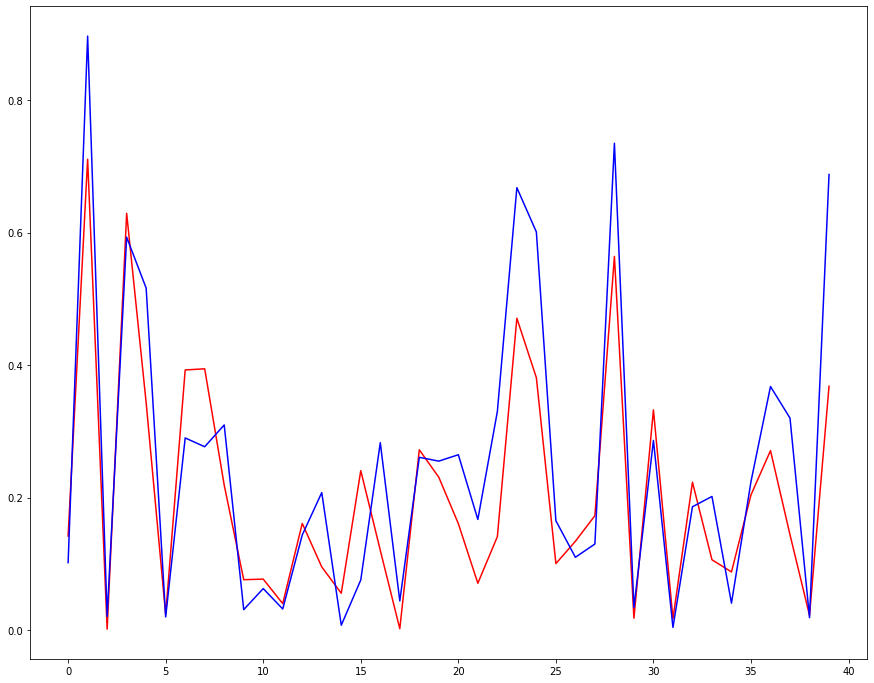

In [69]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?
**Addition is merely multiplying the label by the number and then adding that to a hidden or c label**

2. Why is multiplication harder for the LSTM to learn?

**True multiplication requires an additional layer (the label gets multiplied by the input, and an additional layer for the current running product gets multiplied by (label * value) product**

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [0]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b

        #it =  torch.sigmoid((self.Wix @ xt) + (self.Wih @ ht) + self.bi) 
        #ft =  torch.sigmoid((self.Wfx @ xt) + (self.Wfh @ ht) + self.bf) 
        #gt =  torch.tanh((self.Wcx @ xt) + (self.Wch @ ht) + self.bc) 
        #ot =   torch.sigmoid((self.Wox @ xt) + (self.Woh @ ht) + self.bo) 

        it = torch.sigmoid(gates[:hiddensz,:]) ##################### TO DO #####################
        ft = torch.sigmoid(gates[hiddensz:2*hiddensz,:]) ##################### TO DO #####################
        gt = torch.tanh(gates[2*hiddensz:3*hiddensz,:]) ##################### TO DO #####################
        ot = torch.sigmoid(gates[3*hiddensz:4*hiddensz,:]) ##################### TO DO #####################
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [0]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [0]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [0]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [79]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.0454
to be or not to be that is the question and eath whand routh jore than than  qare dore zore fore dore  eare zor ghand and whand pare youth jore chand the zore than  couth not beath eath the  dare jore or qouth zore eath pare in routh whand ghand  nouth  gare dore ghand or jouth whand routh eath qore than eath chand more and eath xouth noth shand zore youth and whand eath the youth zore routh beath the bath and noth pare fore routh more zore eath kor ind whand whand lore veath the nor lore jouth dore math more kore veath houth houth or lore sore nor hath ure dore ureand houth or ghand qore lore core or the veath beath lore ind lore sore math the ind youth lore sore lore kore veath lore xouth veath xouth than qore fore fore veath in xouth shand kore ghand jore youth dore kore sore dore than dore jouth lore pare sore fore youth whand xouth qore xouth in whand sore and the dore and the lore youth zore fore ghand houth whand youth  vare qor veath g

# Questions

1. What is the purpose of truncated back-prop? 


**Reduce how much work we have to do during back-prop, and also allow us to focus more learning from recent memory instead of old memory **

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more

**Yes, the hidden state (and the C layer) still propagates forward, without being erased, so it is possible for it to learn **